Задание

- Выберите ряд из первого задания.
- Постройте его модель ARIMA.
- Оформите отчёт в Jupyter-ноутбук.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt


import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import warnings
from statistics import NormalDist

warnings.filterwarnings('ignore')

In [2]:
def test_stationarity(timeseries):
#     print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    print(test_stationarity(y))
        
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')

        ts_ax.set_title('Original')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        plt.show()

# Get and plot initial Series

Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


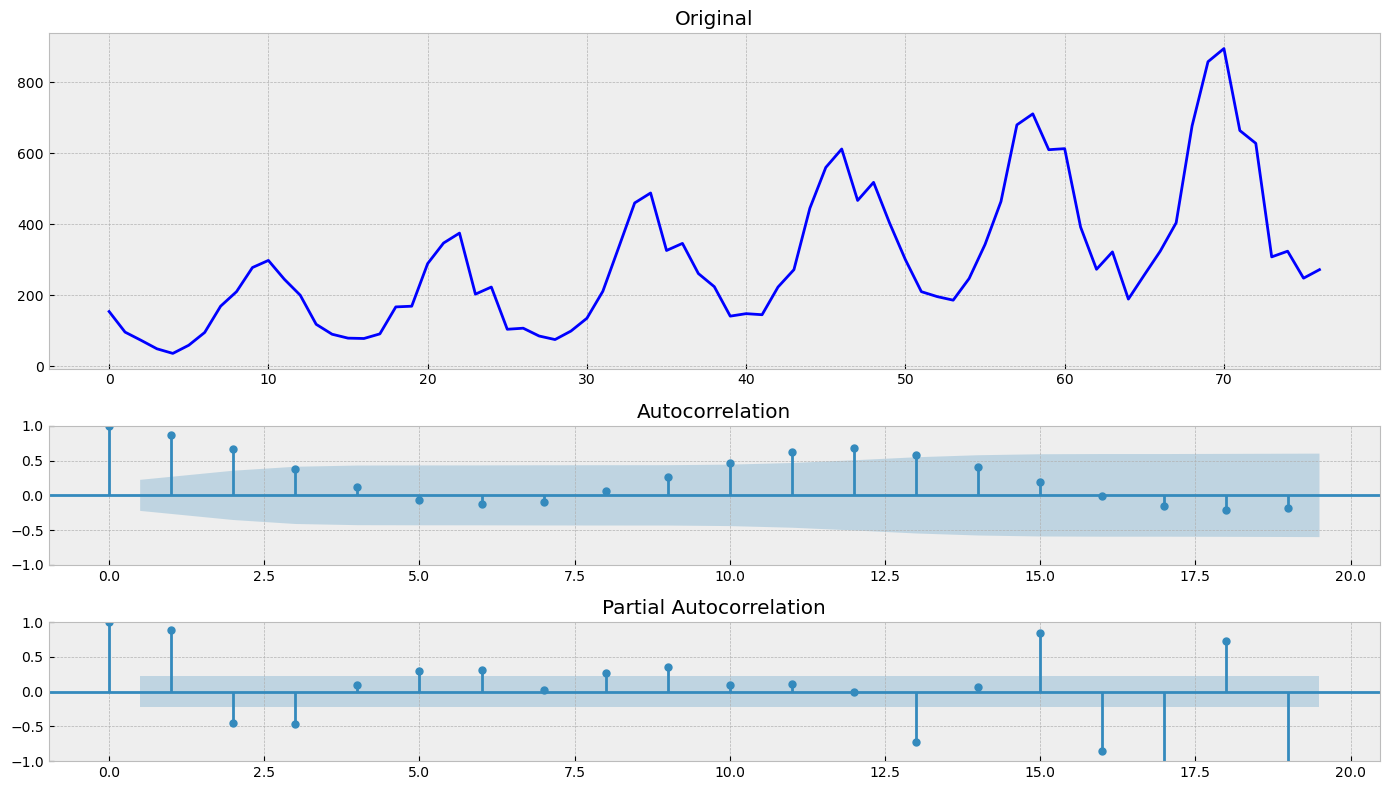

In [28]:
path = 'C:/Users/Igor/Learning/Machine Learning/Netology/3. TimeSeries/Series'
data = next(os.walk(f'{path}'), (None, None, []))[2]
series = pd.read_csv(f'{path}/{data[4]}').iloc[:, -1]

tsplot(series)

# Find best coefficients

In [29]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j), trend='t').fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 849.88610 | order: (3, 1, 2)


# Check model with the best hyper-parameters

Test Statistic                 -1.732954
p-value                         0.414219
#Lags Used                     11.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


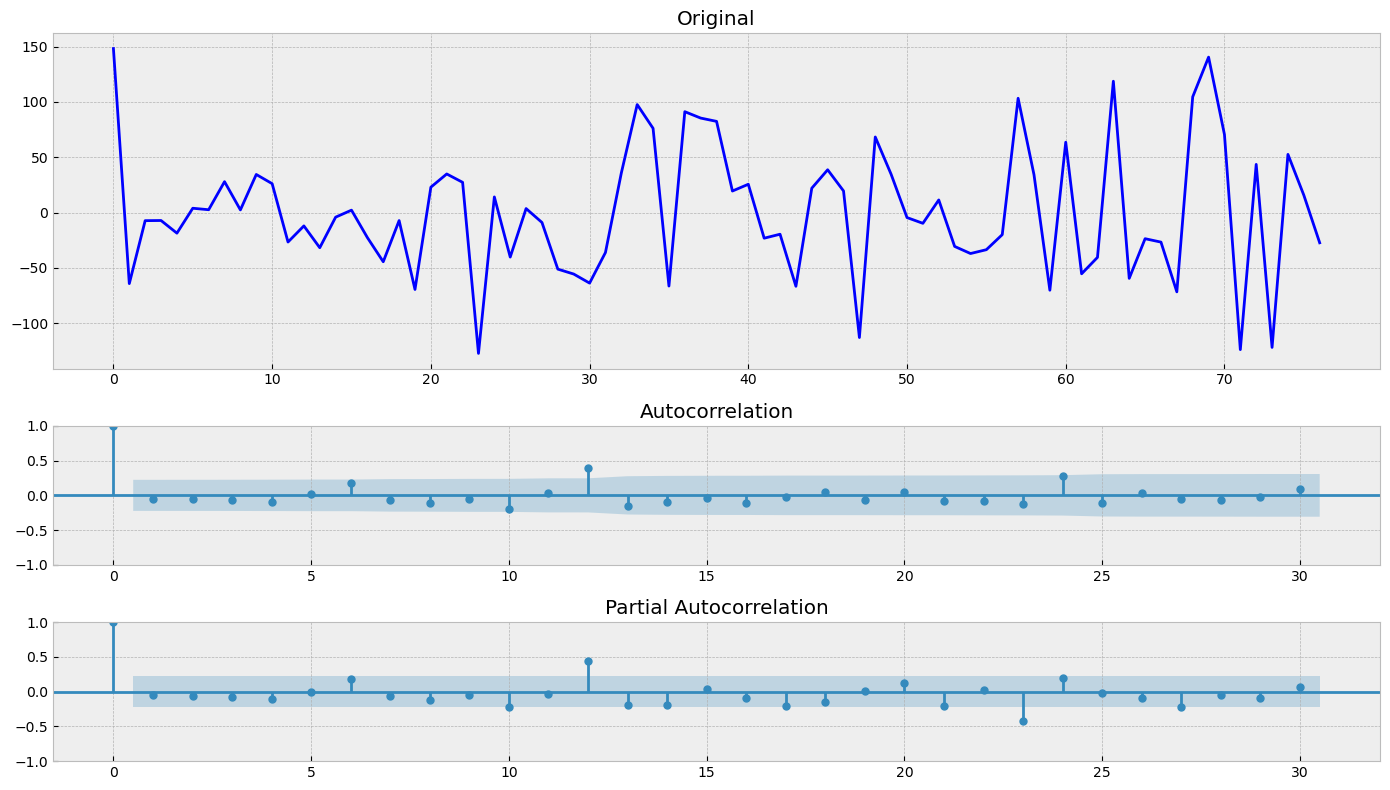

In [37]:
tsplot(best_mdl.resid, lags=30)

# Plot ARIMA prediction

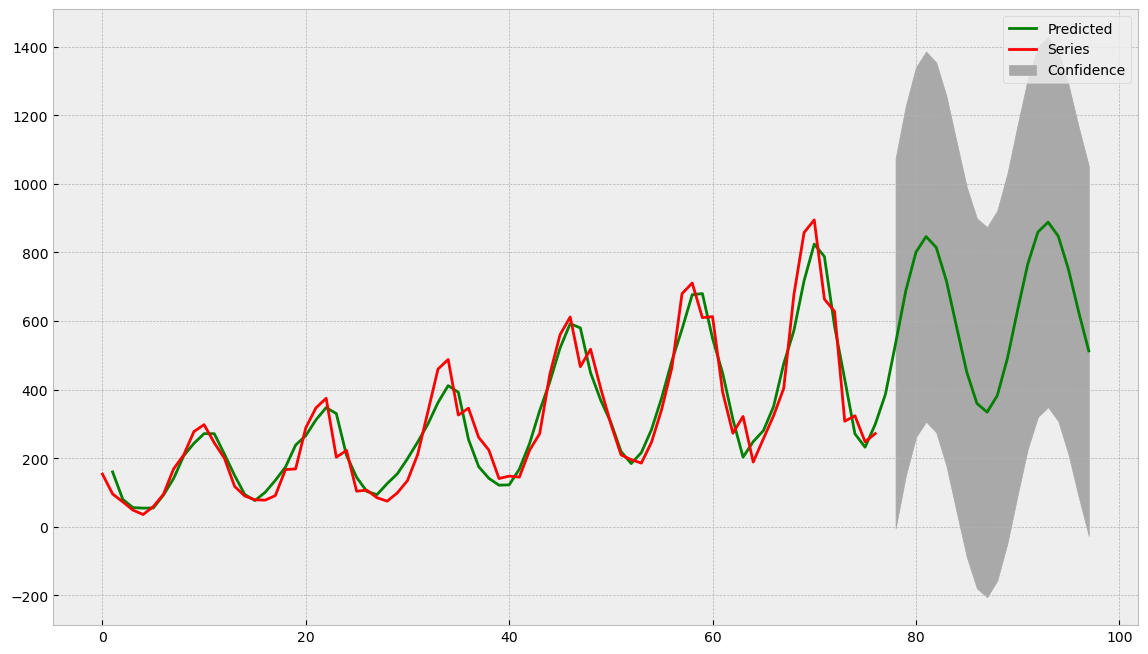

In [32]:
pred_series = best_mdl.predict(1, len(series)+20)
norm_dist = NormalDist.from_samples(pred_series[-20:])
upper = [i + norm_dist.stdev * 3 for i in pred_series[-20:]] #3 sigma
lower = [i - norm_dist.stdev * 3 for i in pred_series[-20:]] #3 sigma

with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(pred_series, color='green', label='Predicted')
    plt.plot(series, color='red', label='Series')
    plt.fill_between(pred_series.index[-20:], upper, lower, color='darkgray', label='Confidence')
    plt.legend()
    plt.show()

# Вывод

- ARIMA так себе нашла коэффициенты и построилась. Нужно делать оптимизацию гиперпараметров (интеллектуально, а не через циклы)
- Доверительный интервал в 3 сигмы представляется не самым реалистичным, но, ожидаемо, должен охватить >90% исходов
- В целом, предсказание выглядит реалистично